## 切割資料集

dataset : https://huggingface.co/datasets/ttxy/ner_movie

is :
https://sparknlp.org/2021/07/20/ner_mit_movie_simple_distilbert_base_cased_en.html

In [1]:
import pandas as pd

def split_data(input_file, train_output, dev_output, dev_size=0.2):
    # 讀取 CSV 檔案
    df = pd.read_csv(input_file)

    # 分割數據集為訓練集和開發集
    train_df = df.sample(frac=(1 - dev_size), random_state=42)  # 使用隨機種子以保證可重現性
    dev_df = df.drop(train_df.index)

    # 寫入訓練集和開發集到各自的文件
    train_df.to_csv(train_output, index=False)
    dev_df.to_csv(dev_output, index=False)

    return len(train_df), len(dev_df)

# 指定輸入檔案和輸出檔案路徑
train_file = 'data_hugging_face/train.csv'
train_output = 'data_hugging_face/train_sub.csv'
dev_output = 'data_hugging_face/dev.csv'

# 執行分割並返回訓練集和開發集的條目數
train_count, dev_count = split_data(train_file, train_output, dev_output)
print(f"train: {train_count}, dev: {dev_count}")

train: 6253, dev: 1563


## csv 轉換成 conll格式(BIO)

In [2]:

import pandas as pd

def convert_to_conll(input_file, output_file):
    # 讀取 CSV 檔案
    df = pd.read_csv(input_file)

    with open(output_file, 'w', encoding='utf-8') as f:
        for index, row in df.iterrows():
            text = row['text']
            tags = row['label'].split(',')
            words = text.split()
            
            # 檢查 words 和 tags 長度是否匹配
            if len(words) != len(tags):
                print(f"Error in row {index}: Word and tag counts do not match.")
                continue

            # 生成 CoNLL 格式的數據
            for word, tag in zip(words, tags):
                
                if labels_to_convert and tag not in labels_to_convert:
                    tag = 'O'
                f.write(f"{word} {tag}\n")
            f.write("\n")  # CoNLL 格式要求句子之間以空行分隔

labels_to_convert = {'I-Actor','B-Actor',
                 'I-Year','B-Year',
                #  'I-Plot','B-Plot',
                 'I-Director','B-Director',
                 'I-Genre','B-Genre',
                 'O'
                 } 

###保留所需之類別


# 指定輸入檔案和輸出檔案路徑
input_file = 'data_hugging_face/test.csv'
output_file = 'data_hugging_face/BIO/test.conll'

# 執行轉換
convert_to_conll(input_file, output_file)


input_file = 'data_hugging_face/train_sub.csv'
output_file = 'data_hugging_face/BIO/train_sub.conll'



input_file = 'data_hugging_face/train.csv'
output_file = 'data_hugging_face/BIO/train.conll'

# 執行轉換
convert_to_conll(input_file, output_file)


# 執行轉換
convert_to_conll(input_file, output_file)

input_file = 'data_hugging_face/dev.csv'
output_file = 'data_hugging_face/BIO/dev.conll'

# 執行轉換
convert_to_conll(input_file, output_file)


## 轉換成spacy (需要時執行)

In [4]:

!spacy convert data_hugging_face/BIO/train_sub.conll -c conll data_hugging_face/spaCy/
!spacy convert data_hugging_face/BIO/dev.conll -c conll data_hugging_face/spaCy/
!spacy convert data_hugging_face/BIO/test.conll -c conll data_hugging_face/spaCy/

ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (6253 documents):
data_hugging_face\spaCy\train_sub.spacy
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (1563 documents):
data_hugging_face\spaCy\dev.spacy
ℹ Grouping every 1 sentences into a document.
⚠ To generate better training data, you may want to group sentences
into documents with `-n 10`.
✔ Generated output file (1953 documents):
data_hugging_face\spaCy\test.spacy


## train spacy model (需要時執行) 

In [5]:

!python -m spacy init config config.cfg --pipeline ner --force

⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: en
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [6]:
!python -m spacy train config.cfg --output ./spacy_model --paths.train data_hugging_face/spaCy/train_sub.spacy --paths.dev data_hugging_face/spaCy/dev.spacy

## spacy 預測

In [ ]:
import spacy
from spacy.tokens import DocBin
from spacy.training import Example
from sklearn.metrics import classification_report, accuracy_score,precision_recall_fscore_support
from sklearn.model_selection import KFold

In [ ]:
import spacy
from spacy.tokens import DocBin
from sklearn.metrics import classification_report, accuracy_score,precision_recall_fscore_support

# 加載訓練好的模型
nlp2 = spacy.load("spacy_model/model-best")

# 讀取測試數據
def read_spacy_data(file_path):
    doc_bin = DocBin().from_disk(file_path)
    return list(doc_bin.get_docs(nlp2.vocab))

test_docs = read_spacy_data("data_hugging_face/spaCy/dev.spacy")

# 評估模型
def evaluate_ner(nlp, test_docs):
    y_true = []
    y_pred = []

    for doc in test_docs:
        gold_labels = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        pred_labels = [(ent.start_char, ent.end_char, ent.label_) for ent in nlp(doc.text).ents]

        gold_dict = {(start, end): label for start, end, label in gold_labels}
        pred_dict = {(start, end): label for start, end, label in pred_labels}

        all_keys = set(gold_dict.keys()).union(set(pred_dict.keys()))

        for key in all_keys:
            y_true.append(gold_dict.get(key, "O"))
            y_pred.append(pred_dict.get(key, "O"))

    # 收集所有可能的標籤，但忽略 "O"

    label = set(y_true + y_pred) - {"O"}

    print("Classification Report:\n", classification_report(y_true, y_pred,labels=list(label)))

    print("============================================")
    print()
    print("spaCy : ")
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.3f}")
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted',labels=list(label))
    print(f"Weighted Average Precision: {precision_w:.3f}")
    print(f"Weighted Average Recall: {recall_w:.3f}")
    print(f"Weighted Average F1 Score: {f1_w:.3f}")
    
    print()
    print("============================================")

evaluate_ner(nlp2, test_docs)

Classification Report:
               precision    recall  f1-score   support

    Director       0.90      0.82      0.86       344
        Year       0.95      0.95      0.95       543
       Genre       0.75      0.72      0.73       724
       Actor       0.94      0.92      0.93       998

   micro avg       0.88      0.86      0.87      2609
   macro avg       0.88      0.85      0.87      2609
weighted avg       0.88      0.86      0.87      2609


spaCy : 
Accuracy: 0.781
Weighted Average Precision: 0.883
Weighted Average Recall: 0.858
Weighted Average F1 Score: 0.870



## NLTK 預測

In [ ]:
import nltk
from nltk.tag import ClassifierBasedTagger
from nltk.chunk import ChunkParserI, conlltags2tree, tree2conlltags
from sklearn.metrics import classification_report, accuracy_score,precision_recall_fscore_support


def read_conll_data(file_path, sep=" ", word_pos=0, iob_pos=1):
    data = []
    sentence = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.strip():
                tokens = line.strip().split(sep)
                if len(tokens) > max(word_pos, iob_pos):
                    word = tokens[word_pos]
                    iob_tag = tokens[iob_pos]
                    sentence.append((word, iob_tag))
                else:
                    raise ValueError(f"Unexpected format in line: {line.strip()}")
            else:
                if sentence:
                    data.append(sentence)
                    sentence = []
    if sentence:
        data.append(sentence)
    return data

train_data = read_conll_data('data_hugging_face/BIO/train.conll')
test_data = read_conll_data('data_hugging_face/BIO/test.conll')

class NamedEntityChunker(ChunkParserI):
    def __init__(self, train_sents):
        # 將數據轉換為 [(token, tag), ...] 格式
        train_data = [[(w, c) for w, c in sent] for sent in train_sents]
        self.tagger = ClassifierBasedTagger(train=train_data, feature_detector=self.features)

    def parse(self, sentence):
        # sentence 是 [(word, 'O'), ...]
        words = [word for word, _ in sentence]
        tagged_pos_tags = self.tagger.tag(words)
        conll_tags = [(word, pos, chunk) for ((word, _), (pos, chunk)) in zip(sentence, tagged_pos_tags)]
        return conlltags2tree(conll_tags)

    def features(self, tokens, index, history):
        word = tokens[index]
        return {
            'word': word,
            'prev-word': '' if index == 0 else tokens[index - 1],
            'next-word': '' if index == len(tokens) - 1 else tokens[index + 1]
        }

# 訓練NER模型
chunker = NamedEntityChunker(train_data)

# 評估模型並輸出结果
def evaluate_model(chunker, test_sents):
    true_tags = []
    pred_tags = []
    results = []

    for sent in test_sents:
        words, true_chunks = zip(*sent)
        true_tags.extend(true_chunks)

        tagged_tree = chunker.parse([(w, 'O') for w in words])
        pred_chunks = [tag for word, pos, tag in tree2conlltags(tagged_tree)]
        pred_tags.extend(pred_chunks)

        # 保存每个句子的结果
        results.append({
            'text': ' '.join(words),
            'true_entities': true_chunks,
            'pred_entities': pred_chunks
        })

    # 計算和輸出評估指标
    print("Classification Report:\n", classification_report(true_tags, pred_tags))
    print("============================================")
    print()
    print("NLTK : ")
    accuracy = accuracy_score(true_tags, pred_tags)
    print(f"Accuracy:{accuracy:.3f}")
    
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(true_tags, pred_tags, average='weighted')
    print(f"Weighted Average Precision: {precision_w:.3f}")
    print(f"Weighted Average Recall: {recall_w:.3f}")
    print(f"Weighted Average F1 Score: {f1_w:.3f}")
    print()
    print("============================================")

evaluate_model(chunker, test_data)


import pickle

def save_model(model, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {file_path}")

# 使用你的模型和指定的文件路徑
# save_model(chunker, 'nltk_ner.pkl')


Classification Report:
               precision    recall  f1-score   support

     B-Actor       0.71      0.97      0.82      1274
  B-Director       0.72      0.75      0.73       425
     B-Genre       0.66      0.78      0.71       789
      B-Year       0.75      0.94      0.83       661
     I-Actor       0.91      0.90      0.90      1553
  I-Director       0.93      0.68      0.78       411
     I-Genre       0.82      0.56      0.66       544
      I-Year       0.50      0.02      0.04        44
           O       0.99      0.97      0.98     33334

    accuracy                           0.95     39035
   macro avg       0.78      0.73      0.72     39035
weighted avg       0.96      0.95      0.95     39035


NLTK : 
Accuracy:0.952
Weighted Average Precision: 0.956
Weighted Average Recall: 0.952
Weighted Average F1 Score: 0.952



##  sklearn_crfsuite 套件下載，需要時執行

In [ ]:
# %pip install sklearn_crfsuite

Note: you may need to restart the kernel to use updated packages.


## CRF預測

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score

# 讀取資料集
def read_data(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        tokens = []
        labels = []
        for line in file:
            if line.strip():
                parts = line.strip().split()
                if len(parts) == 2:
                    token, label = parts
                    tokens.append(token)
                    labels.append(label)
            else:
                if tokens and labels:
                    data.append(list(zip(tokens, labels)))
                    tokens = []
                    labels = []
        if tokens and labels:
            data.append(list(zip(tokens, labels)))
    return data



# 提取特徵
def word2features(sent, i):
    word = sent[i][0]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for _, label in sent]

def sent2tokens(sent):
    return [token for token, _ in sent]


train_data = read_data('data_hugging_face/BIO/train.conll')
test_data = read_data('data_hugging_face/BIO/test.conll')

# 准備資料
train_sents = train_data
test_sents = test_data

X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]


X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

import sklearn_crfsuite
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# 訓練CRF模型
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=False
)

crf.fit(X_train, y_train)

# 預测和评估
y_pred = crf.predict(X_test)

# 平坦化标签
flat_true_labels = [item for sublist in y_test for item in sublist]
flat_pred_labels = [item for sublist in y_pred for item in sublist]


# # 使用 sklearn 的 classification_report 進行評估
report = classification_report(flat_true_labels, flat_pred_labels)
print(report)

# 計算準確度
accuracy = accuracy_score(flat_true_labels, flat_pred_labels)
print("============================================")
print()
print("*CRF : ")
print(f"Accuracy: {accuracy:.3f}")

# 計算加權平均的精确度、召回率和F1分数
precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(flat_true_labels, flat_pred_labels, average='weighted')
print(f"Weighted Average Precision: {precision_w:.3f}")
print(f"Weighted Average Recall: {recall_w:.3f}")
print(f"Weighted Average F1 Score: {f1_w:.3f}")
print()
print("============================================")


import pickle

def save_crf_model(model, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(model, file)
    print(f"Model saved to {file_path}")

save_crf_model(crf, 'self-train-model/crf_ner_model.pkl')

              precision    recall  f1-score   support

     B-Actor       0.93      0.92      0.93      1274
  B-Director       0.86      0.82      0.84       425
     B-Genre       0.84      0.79      0.81       789
      B-Year       0.95      0.97      0.96       661
     I-Actor       0.94      0.93      0.93      1553
  I-Director       0.91      0.84      0.87       411
     I-Genre       0.83      0.73      0.78       544
      I-Year       0.64      0.64      0.64        44
           O       0.98      0.99      0.99     33334

    accuracy                           0.97     39035
   macro avg       0.88      0.85      0.86     39035
weighted avg       0.97      0.97      0.97     39035


*CRF : 
Accuracy: 0.974
Weighted Average Precision: 0.973
Weighted Average Recall: 0.974
Weighted Average F1 Score: 0.973

Model saved to self-train-model/crf_ner_model.pkl


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import KFold
import numpy as np

# 數據準備
X = [sent2features(s) for s in train_data + test_data]  # 使用全部數據生成特徵
y = [sent2labels(s) for s in train_data + test_data]  # 使用全部數據生成標籤

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 初始化用於儲存每次分數的列表
f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []

i = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]

    # 建立 CRF 模型
    crf = sklearn_crfsuite.CRF(
        algorithm='lbfgs', 
        c1=0.1, 
        c2=0.1, 
        max_iterations=100, 
        all_possible_transitions=False
    )
    crf.fit(X_train, y_train)

    # 進行預測
    y_pred = crf.predict(X_test)
    flat_pred_labels = [item for sublist in y_pred for item in sublist]
    flat_true_labels = [item for sublist in y_test for item in sublist]

    # 計算各項指標
    f1 = f1_score(flat_true_labels, flat_pred_labels, average='weighted')
    precision = precision_score(flat_true_labels, flat_pred_labels, average='weighted')
    recall = recall_score(flat_true_labels, flat_pred_labels, average='weighted')
    accuracy = accuracy_score(flat_true_labels, flat_pred_labels)

    # 儲存分數
    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

    # 輸出該次的結果
    print(f"Fold results:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    flat_pred_labels = [item for sublist in y_pred for item in sublist]
    flat_true_labels = [item for sublist in y_test for item in sublist]

    # 輸出該次的評估報告
    report = classification_report(flat_true_labels, flat_pred_labels)
    print(f"Fold {i + 1} Classification Report:")
    print(report)
    i+=1
    print("============================================")

# 輸出交叉驗證的總結結果
print("Cross-validated Precision: ", np.mean(precision_scores))
print("Cross-validated Recall: ", np.mean(recall_scores))
print("Cross-validated F1 Score: ", np.mean(f1_scores))
print("Cross-validated Accuracy: ", np.mean(accuracy_scores))



Fold results:
Precision: 0.9736
Recall: 0.9744
F1 Score: 0.9739
Accuracy: 0.9744
Fold 1 Classification Report:
              precision    recall  f1-score   support

     B-Actor       0.96      0.93      0.95      1251
  B-Director       0.88      0.82      0.85       440
     B-Genre       0.84      0.78      0.81       835
      B-Year       0.96      0.96      0.96       650
     I-Actor       0.96      0.94      0.95      1544
  I-Director       0.92      0.85      0.88       403
     I-Genre       0.82      0.69      0.75       586
      I-Year       0.63      0.57      0.60        42
           O       0.98      0.99      0.99     33477

    accuracy                           0.97     39228
   macro avg       0.88      0.84      0.86     39228
weighted avg       0.97      0.97      0.97     39228

Fold results:
Precision: 0.9742
Recall: 0.9748
F1 Score: 0.9744
Accuracy: 0.9748
Fold 2 Classification Report:
              precision    recall  f1-score   support

     B-Actor      

[0.9738581815125757, 0.9743900459230506, 0.9704008475967723, 0.9736495125346509, 0.9733250157230969]


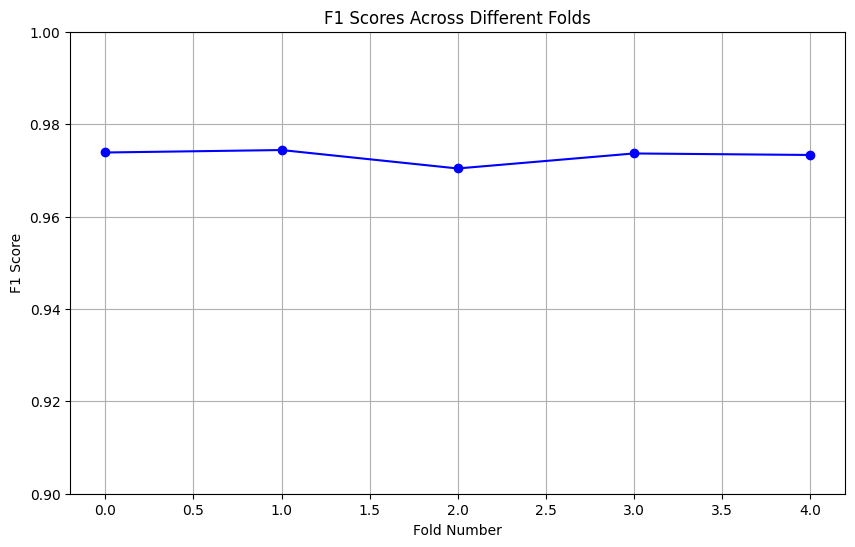

In [ ]:

import matplotlib.pyplot as plt

# 設置圖片大小
plt.figure(figsize=(10, 6))

print(f1_scores)
# 繪製 F1 分數
plt.plot(f1_scores, marker='o', linestyle='-', color='b')

# 添加標題和軸標籤
plt.title('F1 Scores Across Different Folds')
plt.xlabel('Fold Number')
plt.ylabel('F1 Score')

# 添加網格
plt.grid(True)

# 設置 y 軸的範圍來更好地觀察變化
plt.ylim(0.90, 1.0)

# 顯示圖表
plt.show()


In [ ]:
import pickle

def load_crf_model(file_path):
    with open(file_path, 'rb') as file:
        model = pickle.load(file)
    print(f"Model loaded from {file_path}")
    return model

# 從檔案載入您的CRF模型
crf = load_crf_model('self-train-model/crf_ner_model.pkl')

Model loaded from self-train-model/crf_ner_model.pkl


[("'Gone", 'O'), ("Girl',", 'O'), ('a', 'O'), ('2014', 'B-Year'), ('mystery', 'B-Genre'), ('thriller', 'I-Genre'), ('directed', 'O'), ('by', 'O'), ('David', 'B-Director'), ('Fincher', 'I-Director'), ('and', 'O'), ('starring', 'O'), ('Ben', 'B-Actor'), ('Affleck,', 'I-Actor'), ('captivates', 'O'), ('audiences', 'O'), ('with', 'O'), ('its', 'O'), ('plot', 'O'), ('twists.', 'O')]
("'Gone", 'O')
("Girl',", 'O')
('a', 'O')
('2014', 'B-Year')
('mystery', 'B-Genre')
('thriller', 'I-Genre')
('directed', 'O')
('by', 'O')
('David', 'B-Director')
('Fincher', 'I-Director')
('and', 'O')
('starring', 'O')
('Ben', 'B-Actor')
('Affleck,', 'I-Actor')
('captivates', 'O')
('audiences', 'O')
('with', 'O')
('its', 'O')
('plot', 'O')
('twists.', 'O')


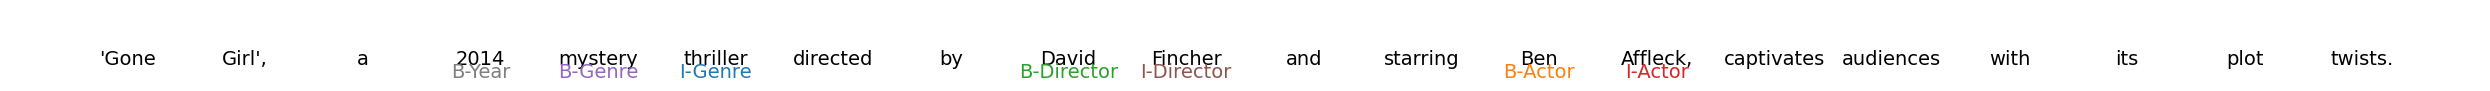

In [ ]:
def extract_features(sentence):
    tokens = sentence.split()
    features_list = []
    
    for i in range(len(tokens)):
        word = tokens[i]
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],
            'word[-2:]': word[-2:],
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
        }
        if i > 0:
            word1 = tokens[i-1]
            features.update({
                '-1:word.lower()': word1.lower(),
                '-1:word.istitle()': word1.istitle(),
                '-1:word.isupper()': word1.isupper(),
            })
        else:
            features['BOS'] = True
        
        if i < len(tokens) - 1:
            word1 = tokens[i+1]
            features.update({
                '+1:word.lower()': word1.lower(),
                '+1:word.istitle()': word1.istitle(),
                '+1:word.isupper()': word1.isupper(),
            })
        else:
            features['EOS'] = True
        
        features_list.append(features)
    
    return [features_list]

def predict(sentence, crf_model):
    features = extract_features(sentence)
    labels = crf_model.predict(features)
    return list(zip(sentence.split(), labels[0]))

# 使用您的句子進行預測
sentence = "'Gone Girl', a 2014 mystery thriller directed by David Fincher and starring Ben Affleck, captivates audiences with its plot twists."
predicted_labels = predict(sentence, crf)
print(predicted_labels)


for i in predicted_labels:
    print(i)

import matplotlib.pyplot as plt
from matplotlib.patches import Patch


def visualize_ner(sent, labels):
    words, tags = zip(*labels)
    unique_tags = list(set(tags))
    # 給每個標籤分配顏色，標籤'O'使用淺灰色，其他使用較鮮豔的顏色
    tag2color = {tag: f"C{i}" if tag != 'O' else "#dddddd" for i, tag in enumerate(unique_tags)}

    plt.figure(figsize=(25, 1))  # 調整畫布大小
    ax = plt.gca()
    
    # 計算單詞之間的間距
    space_between_words = 1
    x_positions = [i * space_between_words for i in range(len(words))]
    
    for i, (word, tag) in enumerate(zip(words, tags)):
        ax.text(x_positions[i], 0, word, color="black", fontsize=14, ha="center", va="bottom")
        # 僅當標籤不是'O'時才顯示顏色標籤
        if tag != 'O':
            ax.text(x_positions[i], 0.1, tag, color=tag2color[tag], fontsize=14, ha="center", va="top")
    
    ax.axis("off")
    ax.set_xlim([0 - space_between_words, x_positions[-1] + space_between_words])  # 調整x軸範圍以更好地適應文字
    plt.tight_layout()  # 這會自動調整子圖參數，以給定的填充適應畫布大小
    plt.show()

# 使用更新的可視化函數
visualize_ner(sentence, predicted_labels)
